# Shrinking the Cross Section Implementation
## (Portfolio Management Coursework)

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn import decomposition
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from scipy.interpolate import interp1d

## Importing Daily Data
We worked with Fama-French 25 portfolios data and 50 anomaly portfolios data, which can be found on Kenneth French's website https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.

These portfolios are obtained computing a set
of characteristics associated with each firm in the CRSP US index. For robustness, small-cap are excluded.

For each characteristic $i$ of a stock $s$ at a given time $t$, (denoted as $c_{s, t}^{i}$) the stocks are sorted based on the values of their respective characteristics $c_{s, t}^{i}$ and ranked cross-sectionally from $1$ to $n_t$, where $n_t$
is the number of stocks at time $t$ for
which this characteristic is available.

Then all ranks are normalized by dividing by $n_t + 1$ to obtain the value of the rank transform:
$$
r c_{s, t}^{i}=\frac{\operatorname{rank}\left(c_{s, t}^{i}\right)}{n_{t}+1}
$$

To obtain the final trasformed characteristics $z_{s, t}^{i}$ the previous quantity are normalized centering them crosssectionally and then dividing by sum of absolute deviations from the mean of all stocks:

$$
z_{s, t}^{i}=\frac{\left(r c_{s, t}^{i}-\overline{rc}_{t}^{i}\right)}{\sum_{s=1}^{n_{t}}\left|r c_{s, t}^{i}-\bar{rc}_{t}^{i}\right|}
$$

where where $\bar{rc}_{t}^{i}=\frac{1}{n_{t}} \sum_{s=1}^{n_{t}} r c_{s, t}^{i}$

Finally, all transformed characteristics $z_{s, t}^{i}$ for all stocks are combined into a matrix of instruments $Z_{t}$, which is used in the analysis.


As a final step characteristics and stock excess returns are interact in the cross-section at each time t to obtain a rotation of the space of N individual stocks returns into a space of H “managed portfolios”
based on such H characteristics.

In [3]:
# Daily Data
f_f_5_factors_d = pd.read_csv('/content/F-F_Research_Data_5_Factors_2x3_daily.csv')
anomalies_50_d = pd.read_csv('/content/managed_portfolios_anom_d_50.csv')
portfolios_25_awr_d = pd.read_csv('/content/25_Portfolios_5x5_Daily_average_value_weighted_returns_daily.csv')

In [3]:
# Transforming the data
ff_5_factors = f_f_5_factors_d
ff_5_factors = ff_5_factors.set_index(ff_5_factors['Date'])
ff_5_factors.drop('Date', axis=1, inplace=True)
ff_5_factors = ff_5_factors.iloc[:,:]

portfolios_25 = portfolios_25_awr_d.copy()
portfolios_25 = portfolios_25.set_index(portfolios_25['Date'])
portfolios_25.drop('Date', axis=1, inplace=True)
portfolios_25 = portfolios_25[portfolios_25.index >='1963/07/01']
portfolios_25 = portfolios_25.sub(ff_5_factors['RF'], axis=0)  # Minusing risk-free rate from portfolio returns to get excess returns

anomalies_50 = anomalies_50_d.copy()
anomalies_50 = anomalies_50.rename(columns={'date': 'Date'})
anomalies_50 = anomalies_50.set_index(portfolios_25[1:].index)
anomalies_50.drop('Date', axis=1, inplace=True)
anomalies_50 = anomalies_50 * 100

portfolios_mkt = ff_5_factors['Mkt-RF']  # This is the market portfolio returns
anomalies_mkt = anomalies_50['rme']

anomalies_50.drop('rme', axis=1, inplace=True)

# Dropping first 2578 indices because some portfolios have NaN's
anomalies_mkt = anomalies_mkt[2578:]
anomalies_50 = anomalies_50.iloc[2578:,:]

In [4]:
def split_data(portfolio_returns, market_returns, IS_date):
    """
    This functions splits the portfolio returns and market portfolio returns into in-sample and out-of-sample data
    IS_date: Final date of in-sample data
    """
    train_returns = portfolio_returns[portfolio_returns.index<=IS_date]
    train_market = market_returns[market_returns.index<=IS_date]
    test_market = market_returns[market_returns.index>IS_date]
    test_returns = portfolio_returns[portfolio_returns.index>IS_date]

    return train_returns, train_market, test_returns, test_market

In [5]:
def regression_against_market(train_returns, train_market):
    """
    This function runs a regression of in-sample training returns against the market portfolio (and a constant).
    It returns the coefficients of the regression.
    train_returns: in-sample portfolio returns
    train_market: in-sample market portfolio returns
    """
    rhs = pd.DataFrame({
    'Constant': 1,
    'Mkt-RF': train_market.values
    }, index=train_market.index)

    beta_fit = pd.DataFrame(
        np.linalg.inv(rhs.T@rhs).dot(np.ma.dot(rhs.T,train_returns)).T,
        columns=rhs.columns,
        index=train_returns.columns)

    return beta_fit

In [6]:
def orthogonalise_returns(train_returns, train_market, test_returns, test_market):
    """
    This function orthognalises the portfolio returns w.r.t the market portfolio.
    It first removes the effect of the market portfolio returns, and then divides by the standard deviation.
    train_returns: in-sample portfolio returns
    train_market: in-sample market portfolio returns
    test_returns: out-of-sample portfolio returns
    test_market: out-of-sample market portfolio returns
    """
    train_returns = train_returns.copy()
    test_returns = test_returns.copy()

    # Portfolio returns minus market portfolio returns multiplied by corresponding regression beta coefficent
    train_returns.loc[:, :] = train_returns.values - np.outer(train_market, beta_fit['Mkt-RF'])
    test_returns.loc[:, :] = test_returns.values - np.outer(test_market, beta_fit['Mkt-RF'])

    # Dividing portfolio returns by standard deviation market portfolio returns
    std_train_returns = np.nanstd(train_returns, axis=0)
    std_matrix_train = np.tile(std_train_returns, (len(train_returns), 1))
    train_returns = train_returns / std_matrix_train * np.nanstd(train_market)

    std_test_returns = np.nanstd(test_returns, axis=0)
    std_matrix_test = np.tile(std_test_returns, (len(test_returns), 1))
    test_returns = test_returns / std_matrix_test * np.nanstd(test_market)

    return train_returns, test_returns

In [7]:
# This function compute the sample covariance matrix and apply a small regularization technique
# wich prevent small eigenvalues to cause problems in the computation of the inverse of the
# sample covariance matrix

def regcov(portfolio_returns):
    """
    This function calculates and returns a covariance matrix (with flat Wishart prior)
    """
    X = np.cov(portfolio_returns, rowvar=False)

    T, n = portfolio_returns.shape
    a = n / (n + T)
    X = a * np.trace(X) / n * np.eye(n) + (1 - a) * X

    return X

In [8]:
def mean_covariance(train_returns, test_returns):
    """
    This function returns the mean and covariance of in-sample and out-of-sample portfolio returns, as well as
    the Q matrix (left singular vectors) and the eigenvalues
    """
    # Calculating mean and covariance matrix for training data
    X_train = regcov(train_returns)
    y_train = np.mean(train_returns, axis=0)

    # Calculating mean and covariance matrix for testing data
    X_test = regcov(test_returns)
    y_test = np.mean(test_returns, axis=0)

    # Eigenvalue decomposition of covariance matrix (eigenvalues sorted in decreasing order)
    Q, eigenvalues, _ = np.linalg.svd(X_train)

    return X_train, y_train, X_test, y_test, Q, eigenvalues

In [9]:
def PC_rotate(train_returns, test_returns, Q_matrix):
    """
    This function rotates the portfolio returns into the principal component space.
    train_returns: in-sample portfolio returns
    test_returns: out-of-sample portfolio returns
    Q_matrix: left singular vectors, obtained from SVD of covariance matrix
    """
    train_returns_pc = np.dot(train_returns, Q_matrix)
    test_returns_pc = np.dot(test_returns, Q_matrix)

    return train_returns_pc, test_returns_pc

## Core functions
The following is the core of the paper.

Indeed, the analysis can be reduced to finding the parameter

$$
\hat{b}=\arg \min _{b}(\bar{\mu}-\Sigma b)^{\prime} \Sigma^{-1}(\bar{\mu}-\Sigma b)+\gamma_{2} b^{\prime}b
$$

in the case of $L^2$ norm penalty, or

$$
\hat{b}=\arg \min _{b}(\bar{\mu}-\Sigma b)^{\prime} \Sigma^{-1}(\bar{\mu}-\Sigma b)+\gamma_{2} b^{\prime}b+\gamma_{1} \sum_{i=1}^{H}\left|b_{i}\right|
$$

in the case of $L^2$ and $L^1$ norm penalty, where $\gamma_{2} = \frac{\tau}{\kappa^2 T}$ and $\tau = tr(\Sigma)$.

Having a method to compute $\hat{b}$ allows  to perform an optimization over the parameters $\kappa$ and $\gamma_1$ using the cross-sectional OOS $R^2$, which represents the predictive accuracy of a regression model trained on cross-sectional data,defined as follows:

$$
R^{2}=1-\frac{\left(\mu_{2}-\Sigma_{2} \hat{b}\right)^{\prime}\left(\mu_{2}-\Sigma_{2} \hat{b}\right)}{\mu_{2}^{\prime} \mu_{2}}
$$

where $\mu_2$ is the OOS sample mean and $\Sigma_2$ is the OOS sample covariance matrix.



In [10]:
def gamma(kappa, T, X, freq):
    """
    This function calculates the L2 penalty (gamma)
    kappa: Square root of expected squared sharpe ratio
    T: Number of rows of (training) returns data
    X: Covariance matrix of returns
    freq: 252 for daily data, 12 for monthly data
    """
    return freq * np.trace(X) / T / kappa**2

def b_hat_L2(X, y, l2penalty, T, compute_errors=False):
    """
    This function calculates the posterior mean of b, i.e. the estimate of the coefficients of the SDF.
    This function uses only the L2 norm penalty specification.
    It returns the estimate of b and the standard errors.
    X: Covariance matrix of returns
    y: Mean vector of returns
    l2penalty: L2 penalty term (gamma)
    compute_errors: Set true to obtain standard errors, to obtain t-statistic of estimates
    """
    if compute_errors:
        Xinv = np.linalg.inv(X + l2penalty * np.eye(X.shape[0]))

        b = Xinv @ y
        se = np.sqrt(1 / T * np.diag(Xinv))
    else:
        # solves a system of linear equation instead if errors are not needed
        b = np.linalg.solve(X + l2penalty * np.eye(X.shape[0]), y)

        se = np.full(X.shape[0], np.nan)

    return b, se


def b_hat_L1L2(X, y, l2penalty, l1penalty):
    """
    This function calculates the posterior mean of b, under the dual-penalty (L1 and L2) specification
    """
    def objective_fn(b, X, y, l1, l2):
        Xinv = np.linalg.inv(X)
        return (y-X@b).T @ Xinv @ (y-X@b) + l2*b.T@b + l1 * np.sum(np.abs(b))

    n = X.shape[0]
    initial_guess = np.ones(n)

    result = minimize(
        objective_fn,
        initial_guess,
        args=(X, y, l1penalty, l2penalty),
        method='L-BFGS-B'
    )
    return result.x

def CSRsquared(y, b, sigma):
    """
    This function returns the Cross-Sectional R squared
    """
    return 1 - (((y - sigma@b).T)@(y - sigma@b)/(y.T@y))

In [11]:
def cross_validation(kappa_grid, splits, train_returns, freq, l1penalty=None):
    """
    This function performs K-fold cross-validation in order to obtain the R squared values for a grid of kappa values.
    The function returns the R squared for in-sample and out-of-sample. The optimal kappa is given by the value of
    kappa which maximises out-of-sample R squared. The L2 penalty specification is used by default.
    kappa_grid: Grid of kappa values
    splits: Number of splits/folds for Kfold cross-validation
    train_ret: Returns of the training data
    freq: 252 if daily data, 12 if monthly
    l1penalty: If a value is passed, the function will perform cross-validation using the L1-L2 dual penalty specification.
    """
    kf = KFold(n_splits=splits, shuffle=False)
    kf.get_n_splits(train_returns)
    R2_OOS = []
    R2_IS =[]
    for kappa in kappa_grid:
        R2 = 0
        R2_2 = 0
        for i, (train_index, test_index) in enumerate(kf.split(train_returns)):
            T1 = train_index.shape[0]
            Sigma_IS = regcov(train_returns.iloc[train_index,:])
            y_bar_IS = np.mean(train_returns.iloc[train_index,:], axis=0)
            Sigma_OS = regcov(train_returns.iloc[test_index,:])
            y_bar_OS = np.mean(train_returns.iloc[test_index,:], axis=0)

            l2penalty = gamma(kappa, T1, Sigma_IS, freq)
            if l1penalty is None:
                b_hat_train = b_hat_L2(Sigma_IS, y_bar_IS, l2penalty, T1, compute_errors=False)
                R2 += CSRsquared(y_bar_OS, b_hat_train[0], Sigma_OS)
                R2_2 += CSRsquared(y_bar_IS, b_hat_train[0], Sigma_IS)
            else:
                b_hat_train = b_hat_L1L2(Sigma_IS, y_bar_IS, l2penalty, l1penalty)
                R2 += CSRsquared(y_bar_OS, b_hat_train, Sigma_OS)
                R2_2 += CSRsquared(y_bar_IS,b_hat_train,Sigma_IS)
        R2_OOS.append(R2/splits)
        R2_IS.append(R2_2/splits)

    return R2_OOS, R2_IS

# Fama-French 25 Portfolios Analysis

In [12]:
train_ret, train_mkt, test_ret, test_mkt = split_data(portfolios_25, portfolios_mkt, "2011/12/31")
beta_fit = regression_against_market(train_ret, train_mkt)

In [13]:
train_ret, test_ret = orthogonalise_returns(train_ret, train_mkt, test_ret, test_mkt)
T, n = train_ret.shape

In [14]:
X, y, X_test, y_test, Q, eigenvalues = mean_covariance(train_ret, test_ret)

In [15]:
train_ret_pc, test_ret_pc = PC_rotate(train_ret, test_ret, Q)

In [16]:
X_pc, y_pc, X_test_pc, y_test_pc, _, _ = mean_covariance(train_ret_pc, test_ret_pc)

As a first step we are gonna plot a one-to-one mapping between κappa and $df(γ)$, where $γ$ is the parameeter of the L2 penalization.

The degrees of freedom of $γ$ correspond to the number of free parameters. We are interested in the kappa realizing $df(γ) = 2$ as this corresponds to the historical choice from the literature of using two parameters to express the model.

Kappa implied by 2 effective degrees of freedom:  0.27194605220720863


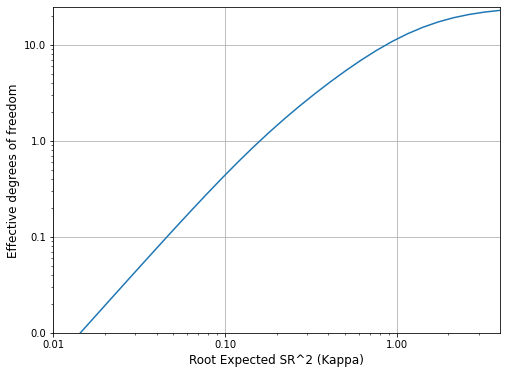

In [17]:
kappa_grid_df_plot = np.logspace(0.6, np.log10(0.01), 30)
gamma_grid_df_plot = gamma(kappa_grid_df_plot, T, X, 252)
df = []
for gam in gamma_grid_df_plot:
    df.append(np.sum(eigenvalues / (eigenvalues + gam)))
lst = np.asarray(df)
idx = (np.abs(lst - 2)).argmin()
print("Kappa implied by 2 effective degrees of freedom: ", kappa_grid_df_plot[idx])
plt.figure(figsize=(8,6))

plt.plot(kappa_grid_df_plot, df)

plt.yscale('log')
plt.yticks(np.add(plt.yticks()[0], 0.0000000000001))

plt.xscale('log')
plt.xticks(np.add(plt.xticks()[0], 0.0000000000001))

plt.ylabel('Effective degrees of freedom', fontsize=12)
plt.xlabel('Root Expected SR^2 (Kappa)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlim([min(kappa_grid_df_plot), max(kappa_grid_df_plot)])
plt.ylim([0.01, 25])
plt.show()

In the following plot instead, we are mapping the IS/OOS Cross Sectional R2 against kappa.

We observe that the maximum OOS Cross Sectional R2 is obtained at kappa similar to the kappa retrieved in the following plot.

Optimal Kappa:  0.23057097013694863


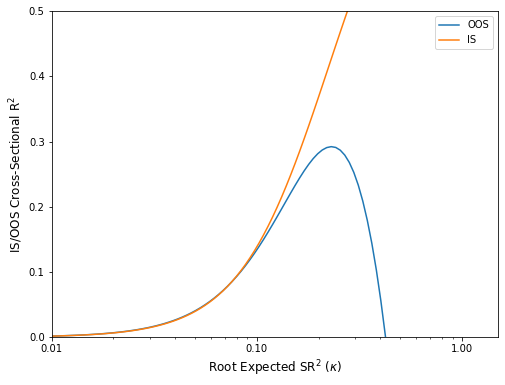

In [18]:
kappa_grid = np.logspace(np.log10(0.01),np.log10(1.5), 100)
R2_OOS, R2_IS = cross_validation(kappa_grid, 3, train_ret, 252)

plt.figure(figsize=(8, 6))
plt.plot(kappa_grid,R2_OOS, label='OOS')
plt.plot(kappa_grid,R2_IS, label='IS')
plt.xscale('log')
plt.xticks(np.add(plt.xticks()[0], 0.0000000000001))
plt.xlim([min(kappa_grid), max(kappa_grid)])
plt.ylim([0, 0.5])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ylabel('IS/OOS Cross-Sectional R$^2$', fontsize=12)
plt.xlabel('Root Expected SR$^2$ ($\kappa$)', fontsize=12)
plt.legend()

kappa_opt = kappa_grid[np.argmax(R2_OOS)]
print('Optimal Kappa: ', kappa_opt)

## Estimating $\hat{b}$ without PCA

Here we show the estimates of $\hat{b}$ using both the optimal $\kappa$ we found, and the papers optimal $\kappa \approx 0.15$

In [19]:
gamma_opt = gamma(kappa_opt, T, X, 252)  # Calculate L2 penalty for our optimal kappa
np.set_printoptions(precision=2, suppress=True)
bhat, se = b_hat_L2(X, y, gamma_opt, T, compute_errors=True)  # Calculate estimate of b and standard errors

kappa_opt2 = 0.15
gamma_opt2 = gamma(kappa_opt2, T, X, 252)  # Calculate L2 penalty for papers optimal kappa
bhat2, se2 = b_hat_L2(X, y, gamma_opt2, T, compute_errors=True)

# Put estimates into a dataframe
raw_25_b = pd.DataFrame(data=bhat*100, index=train_ret.columns, columns=[f'b (Kappa = {round(kappa_opt, 3)})'])
raw_25_b2 = pd.DataFrame(data=bhat2*100, index=train_ret.columns, columns=[f'b (Kappa = {round(kappa_opt2, 3)})'])

# Obtain top 5 largest and top 5 smallest coefficients in each case and calculate corresponding t-statistic
raw_25_b_10_factors = pd.concat([raw_25_b.nlargest(5, raw_25_b.columns[0]), raw_25_b.nsmallest(5, raw_25_b.columns[0])[::-1]])
raw_25_b_10_factors[f't-stat (Kappa = {round(kappa_opt, 3)})'] = abs(raw_25_b_10_factors[f'b (Kappa = {round(kappa_opt, 3)})']/ se[:10]/100)
raw_25_b_10_factors[f'b (Kappa = {round(kappa_opt2, 3)})'] = pd.concat([raw_25_b2.nlargest(5, raw_25_b2.columns[0]), raw_25_b2.nsmallest(5, raw_25_b2.columns[0])[::-1]])
raw_25_b_10_factors[f't-stat (Kappa = {round(kappa_opt2, 3)})'] = abs(raw_25_b_10_factors[f'b (Kappa = {round(kappa_opt2, 3)})']/ se2[:10]/100)
raw_25_b_10_factors = raw_25_b_10_factors.fillna(0)
raw_25_b_10_factors.round(2)

,b (Kappa = 0.231),t-stat (Kappa = 0.231),b (Kappa = 0.15),t-stat (Kappa = 0.15)
SMALL HiBM,0.37,1.32,0.18,1.00
ME1 BM4,0.31,1.12,0.16,0.86
ME3 BM5,0.30,1.06,0.15,0.83
ME4 BM4,0.30,1.06,0.15,0.82
ME3 BM4,0.29,1.04,0.15,0.82
ME4 BM1,0.01,0.03,0.00,0.00
ME5 BM4,-0.05,0.18,-0.01,0.06
ME3 BM1,-0.16,0.57,-0.06,0.35
ME2 BM1,-0.22,0.78,-0.08,0.45
SMALL LoBM,-0.37,1.31,-0.14,0.78


## Estimating $\hat{b}$ with PCA

In [20]:
# Rotate portfolio returns into PC space
train_ret_pc, test_ret_pc = PC_rotate(train_ret, test_ret, Q)

In [21]:
# Calculate the estimates of b and standard error with PC portfolio returns
# Using same kappa as previous part
bhat_pc, se_bc = b_hat_L2(X_pc, y_pc, gamma_opt, T, compute_errors=True)
pc_25_b = pd.DataFrame(data=bhat_pc*100, index=[f'PC{i}' for i in range(1, 26)], columns=[f'b (Kappa = {round(kappa_opt, 3)})'])
pc_25_b[f't-stat (Kappa = {round(kappa_opt2, 3)})'] = abs(pc_25_b[f'b (Kappa = {round(kappa_opt, 3)})'] / se_bc/100)
pc_25_b = pc_25_b.sort_values(by=f't-stat (Kappa = {round(kappa_opt2, 3)})', ascending=False)

bhat_pc2, se_bc2 = b_hat_L2(X_pc, y_pc, gamma_opt2, T, compute_errors=True)
pc_25_b2 = pd.DataFrame(data=bhat_pc2*100, index=[f'PC{i}' for i in range(1, 26)], columns=[f'b (Kappa = {round(kappa_opt2, 3)})'])
pc_25_b2[f't-stat (Kappa = {round(kappa_opt2, 3)})'] = abs(pc_25_b2[f'b (Kappa = {round(kappa_opt2, 3)})'] / se_bc2/100)
pc_25_b2 = pc_25_b2.sort_values(by=f't-stat (Kappa = {round(kappa_opt2, 3)})', ascending=False)

res_df = pd.concat([pc_25_b, pc_25_b2], axis=1)
res_df.round(2).head(10)

,b (Kappa = 0.231),t-stat (Kappa = 0.15),b (Kappa = 0.15),t-stat (Kappa = 0.15)
PC1,-0.52,2.61,-0.32,2.04
PC5,-0.48,1.74,-0.21,1.16
PC2,0.42,1.72,0.21,1.22
PC14,-0.21,0.74,-0.09,0.49
PC11,-0.19,0.69,-0.08,0.45
PC23,-0.19,0.65,-0.08,0.42
PC20,0.17,0.61,0.07,0.40
PC19,0.17,0.60,0.07,0.39
PC17,-0.17,0.59,-0.07,0.39
PC10,0.12,0.44,0.05,0.29


### Plotting SDF Coefficient b against Root Expected SR$^2$

We are plotting paths of coefficients associated with each PC in the final SDF as a
function of strength of regularization, as measured by κ.

The right edge of the plot corresponds to the unregularized OLS solution. Labels are ordered
according to absolute values of OLS coefficients in a descending order.

As we increase the strength of
the penalty (move to the left), coefficients shrink toward zero and the model-SDF approaches
the risk-neutral SDF.

We can see that shrinkage is stronger
for small PCs and weaker for large PCs, which reflects our prior belief that small PCs are
unlikely to be important in the SDF

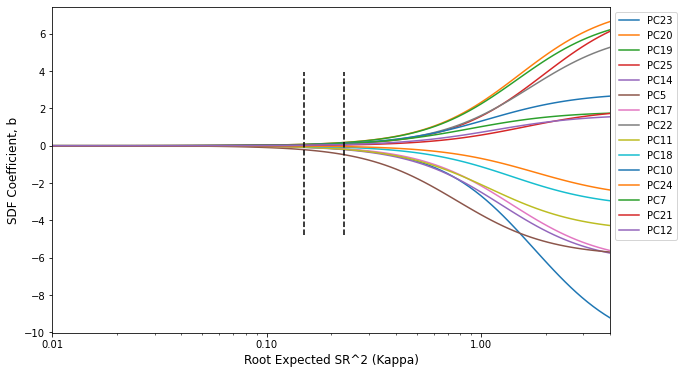

In [22]:
# Plotting b estimates against kappa

kappas = np.logspace(np.log10(0.01),np.log10(4), 100)
pc_coefficients = []
kappa_pc_df = pd.DataFrame(columns=[f'PC{i}' for i in range(1, 26)], index=kappas)
# kappa_pc_df = pd.DataFrame(columns=kappa_pc_df.iloc[-1, :].abs().sort_values().index, index=kappas)
for i, kappa in enumerate(kappas):
    kappa_pc_df.iloc[i,:] = (b_hat_L2(X_pc, y_pc, gamma(kappa, T, X_pc, 252), T, compute_errors=False)[0])*100

# Sorting by absolute value of the coefficients
sorted_df = kappa_pc_df[kappa_pc_df.iloc[-1, :].abs().sort_values(ascending=False).index]

plt.figure(figsize=(10, 6))
for i in range(15):
    plt.plot(kappas, sorted_df.iloc[:,i].values, label=sorted_df.columns[i])
#     plt.plot(kappas, kappa_pc_df.iloc[:,i].values, label=kappa_pc_df.columns[i])
plt.xscale('log')
plt.xticks(np.add(plt.xticks()[0], 0.0000000000001))

plt.axvline(x=kappa_opt, color='black', linestyle='--', ymin=0.3, ymax=0.8)
plt.axvline(x=kappa_opt2, color='black', linestyle='--', ymin=0.3, ymax=0.8)

plt.ylabel('SDF Coefficient, b', fontsize=12)
plt.xlabel('Root Expected SR^2 (Kappa)', fontsize=12)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim([min(kappas), max(kappas)])
plt.show()

Now, we are going to plot the maximum cross-sectional R2 achievable by a sparse model with n factors.

We explore sparsity both in the space of characteristics and PCs.

We see that we can obtain much sparser SDF
representations in PC space rather than in original space of characteristics.

We observe that including more than two PCs barely improves the model performance, suggesting that sparse models formed from a few large PCs can approximate the SDF quite well.

In [23]:
coeff_R2_dict = {}
gamma_opt = gamma(kappa_opt, T, X, 252)
for i in np.insert(np.logspace(np.log10(0.005),np.log10(0.2), 40), 0, 0):
    b = b_hat_L1L2(X, y, gamma_opt, i)
    non_zero_coeff = np.sum(abs(b*100) > 0.001)
    if non_zero_coeff not in coeff_R2_dict:
        R2 = CSRsquared(y_test, b, X_test)
        coeff_R2_dict[non_zero_coeff] = R2
    else:
        continue

myKeys = list(coeff_R2_dict.keys())
myKeys.sort()
coeff_R2_dict = {i: coeff_R2_dict[i] for i in myKeys}

In [24]:
coeff_R2_dict_pc = {}
for i in np.insert(np.logspace(np.log10(0.000001),np.log10(0.2), 40), 0, 0):
    b = b_hat_L1L2(X_pc, y_pc, gamma_opt, i)
    non_zero_coeff = np.sum(abs(b*100) > 0.001)
    if non_zero_coeff not in coeff_R2_dict_pc:
        R2 = CSRsquared(y_test_pc, b, X_test_pc)
        coeff_R2_dict_pc[non_zero_coeff] = R2
    else:
        continue

myKeys = list(coeff_R2_dict_pc.keys())
myKeys.sort()
coeff_R2_dict_pc = {i: coeff_R2_dict_pc[i] for i in myKeys}

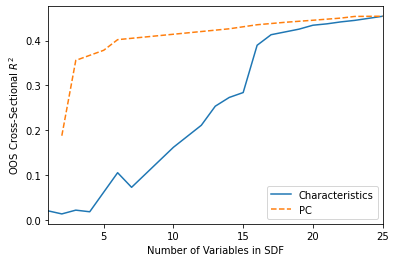

In [25]:
plt.plot(coeff_R2_dict.keys(), coeff_R2_dict.values(), label='Characteristics')
plt.plot(coeff_R2_dict_pc.keys(), coeff_R2_dict_pc.values(), label='PC', linestyle='--')
plt.xlim(1,25)
plt.legend()
plt.ylabel('OOS Cross-Sectional $R^2$')
plt.xlabel('Number of Variables in SDF')
plt.show()

### Plotting Colourmap of $R^2$ against L1 Penalty and Root Expected SR$^2$

The following two plots represent the IS/OOS Cross Sectional R2 against kappa (which corresponds to L2 penalization) and the L1 penalization.

We observe that the kappa that maximize the IS/OOS Cross Sectional R2 remain stable and the L1 penalization does not affect the IS/OOS Cross Sectional R2 until it reaches some values where it completely annihilates IS/OOS Cross Sectional R2 to 0.

Similar behaviors can be seen in both versions of plot, The first being the raw version and the second being the PC 25 portfolios version.

Note: obtaining the plot requires a lot of computation, so we pre-computed it and imported it to plot it. However, we have left the code below which we used to obtain the plots.

In [26]:
# This is how we get the matrix to plot the graphs

#grid_size = 50
#kappa_grid = np.logspace(np.log10(0.01),np.log10(0.8), grid_size)
#gamma_grid = gamma(kappa_grid, T, X, 252)
#l1_grid = np.logspace(np.log10(0.0001),np.log10(0.15), 50)
#splits=3
#freq = 252
# kf = KFold(n_splits=splits, shuffle=False)
# kf.get_n_splits(train_ret)
# R2_OOS = np.zeros((grid_size, grid_size))
# for i, kappa in enumerate(kappa_grid):
#     for j, l1 in enumerate(l1_grid):
#         R2=0
#         for (train_index, test_index) in (kf.split(train_ret)):
#             T1 = train_index.shape[0]
#             Sigma1 = regcov(train_ret.iloc[train_index,:])
#             Sigma2 = regcov(train_ret.iloc[test_index,:])
#             y_bar = np.mean(train_ret.iloc[test_index,:], axis=0)
#             y_bar_IS = np.mean(train_ret.iloc[train_index,:], axis=0)
#             l2penalty = gamma(kappa, T1, Sigma1, freq)
#             b_hat_train = b_hat_L1L2(Sigma1, y_bar_IS, l2penalty, l1)
#             R2 += CSRsquared(y_bar,b_hat_train,Sigma2)
#         R2_OOS[i,j] = R2/splits

In [27]:
# This is the plot if file is not imported

# R2_OOS[R2_OOS < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

# X_plot, Y_plot = np.meshgrid(kappa_grid, l1_grid)
# Z = R2_OOS.T
# plt.figure(figsize=(8,6))

# levels = np.linspace(R2_OOS.min(), R2_OOS.max(), 18)
# contour_plot = plt.contourf(X_plot, Y_plot, Z, levels=levels, cmap='viridis', linestyles=':')

# # plt.imshow(Z, extent = (np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', aspect = 'auto')
# # plt.imshow(Z, origin='lower')
# plt.colorbar(label='Contour Values')

# plt.xlabel('Kappa')
# plt.ylabel('L1')

# plt.xscale('log')
# plt.xlim([min(kappa_grid), max(kappa_grid)])
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# plt.yscale('log')
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# plt.show()

In [29]:
imported_R2_OOS_df = pd.read_csv('/content/R2_OOS.csv')
imported_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

In [ ]:
imported_R2_OOS_df = pd.read_csv('C:/Users/loren/Desktop/Imperial College/Portfolio Management/Project/R2_OOS.csv')
imported_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

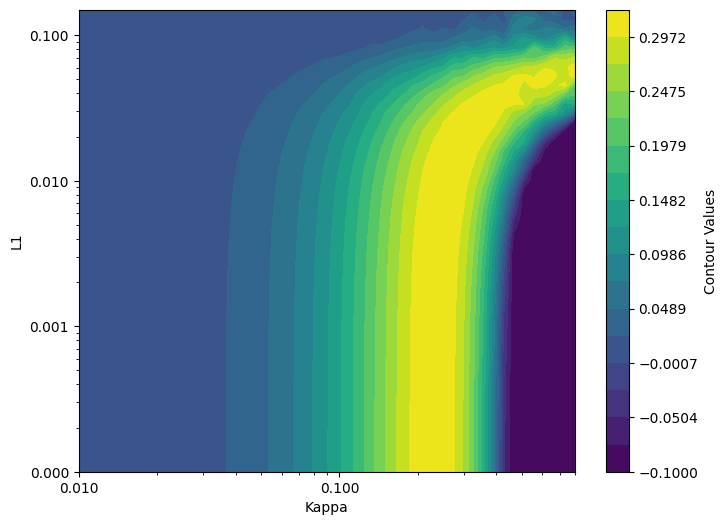

In [30]:
grid_size = 50
kappa_grid = np.logspace(np.log10(0.01),np.log10(0.8), grid_size)
gamma_grid = gamma(kappa_grid, T, X, 252)
l1_grid = np.logspace(np.log10(0.0001),np.log10(0.15), 50)

imported_R2_OOS_df[imported_R2_OOS_df < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

X_plot, Y_plot = np.meshgrid(kappa_grid, l1_grid)
Z = imported_R2_OOS_df.values.T
plt.figure(figsize=(8,6))

levels = np.linspace(imported_R2_OOS_df.values.min(), imported_R2_OOS_df.values.max(), 18)
contour_plot = plt.contourf(X_plot, Y_plot, Z, levels=levels, cmap='viridis', linestyles=':')

# plt.imshow(Z, extent = (np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', aspect = 'auto')
# plt.imshow(Z, origin='lower')
plt.colorbar(label='Contour Values')

plt.xlabel('Kappa')
plt.ylabel('L1')

plt.xscale('log')
plt.xlim([min(kappa_grid), max(kappa_grid)])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()

As before, due to long computations, we pre-computed the data and imported it to plot the graphs. The code commented out below is the code we used to obtain the plots.

In [ ]:
# This is to obtain pc matrix

# train_ret_pc_df = pd.DataFrame(data=train_ret_pc, index=train_ret.index, columns=train_ret.columns)
# splits=3
# freq = 252
# kf = KFold(n_splits=splits, shuffle=False)
# kf.get_n_splits(train_ret_pc)
# R2_OOS_pc = np.zeros((grid_size, grid_size))
# for i, kappa in enumerate(kappa_grid):
#     for j, l1 in enumerate(l1_grid):
#         R2=0
#         for (train_index, test_index) in (kf.split(train_ret_pc_df)):
#             T1 = train_index.shape[0]
#             Sigma1 = regcov(train_ret_pc_df.iloc[train_index,:])
#             Sigma2 = regcov(train_ret_pc_df.iloc[test_index,:])
#             y_bar = np.mean(train_ret_pc_df.iloc[test_index,:], axis=0)
#             y_bar_IS = np.mean(train_ret_pc_df.iloc[train_index,:], axis=0)
#             l2penalty = gamma(kappa, T1, Sigma1, freq)
#             b_hat_train = b_hat_L1L2(Sigma1, y_bar_IS, l2penalty, l1)
#             R2 += CSRsquared(y_bar,b_hat_train,Sigma2)
#         R2_OOS_pc[i,j] = R2/splits

In [ ]:
#df_matrix = pd.DataFrame(R2_OOS, index=kappa_grid, columns=l1_grid)
#df_matrix.to_csv("R2_OOS.csv")

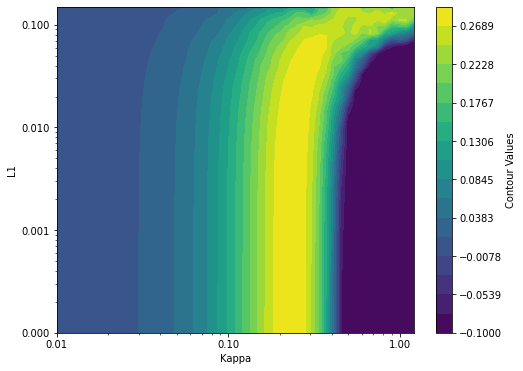

In [ ]:
# This is the plot without importing

# R2_OOS_pc[R2_OOS_pc < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

# X_plot_pc, Y_plot_pc = np.meshgrid(kappa_grid, l1_grid)
# Z = R2_OOS_pc.T
# plt.figure(figsize=(8,6))

# levels = np.linspace(R2_OOS_pc.min(), R2_OOS_pc.max(), 18)
# contour_plot = plt.contourf(X_plot_pc, Y_plot_pc, Z, levels=levels, cmap='viridis', linestyles=':')

# # plt.imshow(Z, extent = (np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', aspect = 'auto')
# # plt.imshow(Z, origin='lower')
# plt.colorbar(label='Contour Values')

# plt.xlabel('Kappa')
# plt.ylabel('L1')

# plt.xscale('log')
# plt.xlim([min(kappa_grid), max(kappa_grid)])
# plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# plt.yscale('log')
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# plt.show()

In [31]:
imported_PC_R2_OOS_df = pd.read_csv('/content/PC_R2_OOS.csv')
imported_PC_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

In [ ]:
imported_PC_R2_OOS_df = pd.read_csv('C:/Users/loren/Desktop/Imperial College/Portfolio Management/Project/PC_R2_OOS.csv')
imported_PC_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

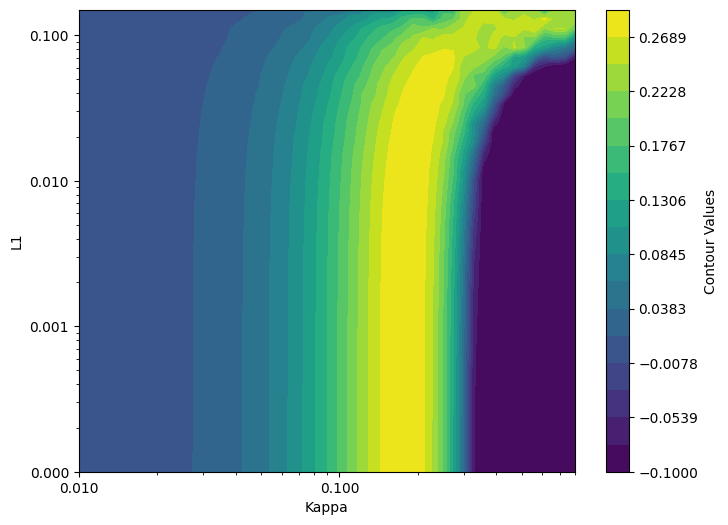

In [32]:
imported_PC_R2_OOS_df[imported_PC_R2_OOS_df < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

X_plot_pc, Y_plot_pc = np.meshgrid(kappa_grid, l1_grid)
Z = imported_PC_R2_OOS_df.values.T
plt.figure(figsize=(8,6))

levels = np.linspace(imported_PC_R2_OOS_df.values.min(), imported_PC_R2_OOS_df.values.max(), 18)
contour_plot = plt.contourf(X_plot_pc, Y_plot_pc, Z, levels=levels, cmap='viridis', linestyles=':')

# plt.imshow(Z, extent = (np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', aspect = 'auto')
# plt.imshow(Z, origin='lower')
plt.colorbar(label='Contour Values')

plt.xlabel('Kappa')
plt.ylabel('L1')

plt.xscale('log')
plt.xlim([min(kappa_grid), max(kappa_grid)])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()

In [ ]:
#df_matrix = pd.DataFrame(R2_OOS_pc, index=kappa_grid, columns=l1_grid)
#df_matrix.to_csv("PC_R2_OOS.csv")

### Plotting SDF Coefficient $b$ against Shrinkage Factor $s$, for both Raw and PC 25 portfolios

The next two plots show how the factor components gets shrinked by the L1 and L2 penalization.

Expacially in the second plot we observe how the greater the ranking of the component the smaller the penalization factor. In fact, the most important components are reduced at the end of the penalty process.

In [33]:
R2_max_idx = np.unravel_index(np.argmax(imported_R2_OOS_df), imported_R2_OOS_df.shape) # Indices at which R squared is maximised

l1_grid_aug = np.insert(l1_grid, 0, 0) # l1_grid starting at 0
b_shrinkage_df = pd.DataFrame(columns=train_ret.columns, index=l1_grid_aug)

# Finding optimal L1 and L2 penalty
l2_shrinkage_opt = gamma(kappa_grid[R2_max_idx[0]], T, X, 252)
l1_shrinkage_opt = l1_grid[R2_max_idx[1]]

b_opt_sum = np.sum(abs(b_hat_L1L2(X, y, l2_shrinkage_opt, l1_shrinkage_opt) * 100)) # Denominator of shrinkage factor, s

# Finding estimate of b for different values of L1 penalty, with L2 penalty fixed at optimal level,
for i, l1 in enumerate(l1_grid_aug):
    b_shrinkage_df.iloc[i, :] = np.array(b_hat_L1L2(X, y, l2_shrinkage_opt, l1) * 100)

# Considering only top 5 largest and top 5 smallest portfolios found in previous part
b_shrinkage_df = b_shrinkage_df[raw_25_b_10_factors.index]

In [34]:
s = abs(b_shrinkage_df).sum(axis=1) / b_opt_sum  # Calculating shrinkage factor s

# Transforming s to be on interval from 0 to 1
s_transformed = (s.values - s.values.min()) / (s.values.max() - s.values.min())

b_shrinkage_df.index = s_transformed # Changing index of dataframe from L1 penalty to transformed values of s

In [35]:
# To make scatter plot sparser in areas where coefficients are very similar
b_shrinkage_df = pd.concat([b_shrinkage_df.iloc[:35:9], b_shrinkage_df.iloc[35:51]])

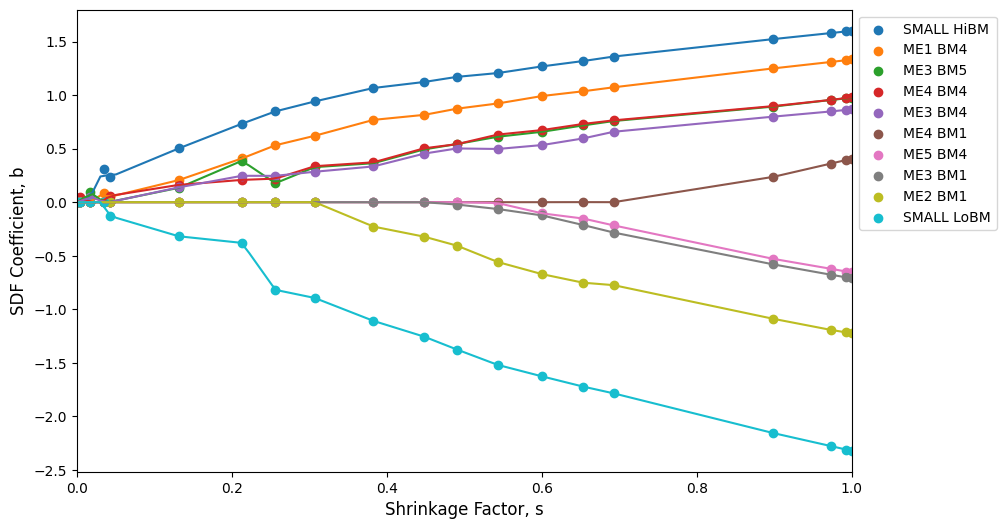

In [36]:
plt.figure(figsize=(10, 6))
for i in range(10):
    # Using scatter plot to plot each point and then linearly interpolating between each point
    plt.scatter(b_shrinkage_df.index, b_shrinkage_df.iloc[:, i].values, marker='o', label=f'{b_shrinkage_df.columns[i]}')

    f = interp1d(b_shrinkage_df.index, b_shrinkage_df.iloc[:, i].values, kind='linear', fill_value='extrapolate')
    x_interpolated = np.linspace(min(b_shrinkage_df.index), max(b_shrinkage_df.index), 100)
    y_interpolated = f(x_interpolated)

    plt.plot(x_interpolated, y_interpolated)

plt.ylabel('SDF Coefficient, b', fontsize=12)
plt.xlabel('Shrinkage Factor, s', fontsize=12)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0,1)
plt.show()

In [37]:
# Doing the same thing for PC portfolios
R2_PC_max_idx = np.unravel_index(np.argmax(imported_PC_R2_OOS_df), imported_PC_R2_OOS_df.shape) # Indices at which R squared is maximised

l1_grid_aug = np.insert(l1_grid, 0, 0) # l1_grid starting at 0
b_shrinkage_df = pd.DataFrame(columns=train_ret.columns, index=l1_grid_aug)

# Finding optimal L1 and L2 penalty
l2_shrinkage_opt = gamma(kappa_grid[R2_PC_max_idx[0]], T, X, 252)
l1_shrinkage_opt = l1_grid[R2_PC_max_idx[1]]

pc_b_shrinkage_df = pd.DataFrame(columns=[f'PC{i}' for i in range(1, 26)], index=l1_grid_aug)
pc_b_opt_sum = np.sum(abs(b_hat_L1L2(X_pc, y_pc, l2_shrinkage_opt, l1_shrinkage_opt) * 100))

for i, l1 in enumerate(l1_grid_aug):
    pc_b_shrinkage_df.iloc[i, :] = np.array(b_hat_L1L2(X_pc, y_pc, l2_shrinkage_opt, l1) * 100)

s_pc = abs(pc_b_shrinkage_df).sum(axis=1) / pc_b_opt_sum
s_pc_transformed = (s_pc.values - s_pc.values.min()) / (s_pc.values.max() - s_pc.values.min())
pc_b_shrinkage_df.index = s_pc_transformed

In [38]:
# To make scatter plot sparser in areas where coefficients are very similar
pc_b_shrinkage_df = pd.concat([pc_b_shrinkage_df.iloc[:35:5], pc_b_shrinkage_df.iloc[35:51:3]])

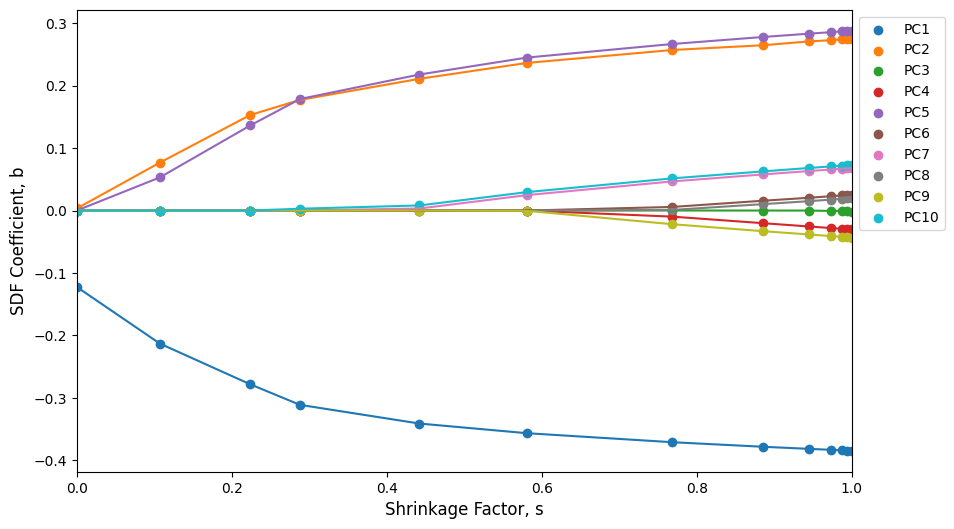

In [39]:
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.scatter(pc_b_shrinkage_df.index, pc_b_shrinkage_df.iloc[:, i].values, marker='o', label=f'{pc_b_shrinkage_df.columns[i]}')

    f = interp1d(pc_b_shrinkage_df.index, pc_b_shrinkage_df.iloc[:, i].values, kind='linear', fill_value='extrapolate')
    x_interpolated = np.linspace(min(pc_b_shrinkage_df.index), max(pc_b_shrinkage_df.index), 100)
    y_interpolated = f(x_interpolated)

    plt.plot(x_interpolated, y_interpolated)

plt.ylabel('SDF Coefficient, b', fontsize=12)
plt.xlabel('Shrinkage Factor, s', fontsize=12)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(0,1)
plt.show()

# 50 Anomaly Portfolios Analysis

In [28]:
train_ret_a, train_mkt_a, test_ret_a, test_mkt_a = split_data(anomalies_50, anomalies_mkt, "2004/12/31")
beta_fit = regression_against_market(train_ret_a, train_mkt_a)
train_ret_a, test_ret_a = orthogonalise_returns(train_ret_a, train_mkt_a, test_ret_a, test_mkt_a)
T_a, n_a = train_ret_a.shape
X_a, y_a, X_test_a, y_test_a, Q_a, eigenvalues_a = mean_covariance(train_ret_a, test_ret_a)
train_ret_pc_a, test_ret_pc_a = PC_rotate(train_ret_a, test_ret_a, Q_a)
X_pc_a, y_pc_a, X_test_pc_a, y_test_pc_a, _, _ = mean_covariance(train_ret_pc_a, test_ret_pc_a)

Optimal Kappa:  0.21919160013789932


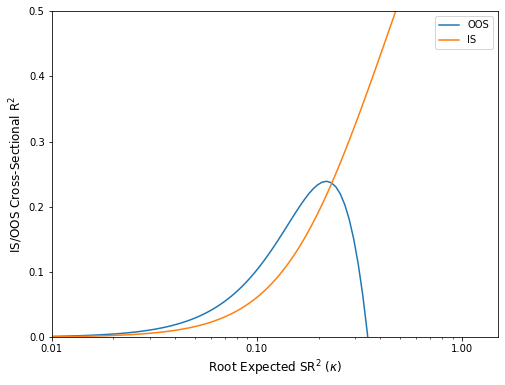

In [29]:
kappa_grid_a = np.logspace(np.log10(0.01),np.log10(1.5), 100)
R2_OOS, R2_IS = cross_validation(kappa_grid_a, 3, train_ret_a, 252)

# Plotting R2 against kappa, using the L2 penalty
plt.figure(figsize=(8, 6))
plt.plot(kappa_grid_a,R2_OOS, label='OOS')
plt.plot(kappa_grid_a,R2_IS, label='IS')
plt.xscale('log')
plt.xticks(np.add(plt.xticks()[0], 0.0000000000001))
plt.xlim([min(kappa_grid_a), max(kappa_grid_a)])
plt.ylim([0, 0.5])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ylabel('IS/OOS Cross-Sectional R$^2$', fontsize=12)
plt.xlabel('Root Expected SR$^2$ ($\kappa$)', fontsize=12)
plt.legend()

kappa_opt_a = kappa_grid_a[np.argmax(R2_OOS)]
print('Optimal Kappa: ', kappa_opt_a)

## Without PCA

In [30]:
gamma_opt_a = gamma(kappa_opt_a, T_a, X_a, 252)

bhat_a, se_a = b_hat_L2(X_a, y_a, gamma_opt_a, T_a, compute_errors=True)

anom_50_b = pd.DataFrame(data=bhat_a*100, index=train_ret_a.columns, columns=[f'b (Kappa = {round(kappa_opt_a, 3)})'])
anom_50_b[f't-stat (Kappa = {round(kappa_opt_a, 3)})'] = abs(anom_50_b[f'b (Kappa = {round(kappa_opt_a, 3)})'] / se_a/100)
anom_50_b = anom_50_b.sort_values(by=f't-stat (Kappa = {round(kappa_opt_a, 3)})', ascending=False)

anom_50_b.head(11)

,b (Kappa = 0.219),t-stat (Kappa = 0.219)
r_indrrevlv,-0.543693,2.781587
r_indmomrev,0.316530,1.618897
r_indrrev,-0.273105,1.396818
r_season,0.214621,1.097627
r_sue,0.184950,0.945860
r_rome,0.181511,0.925420
r_valprof,0.178857,0.913290
r_ciss,-0.150587,0.768426
r_inv,-0.148822,0.759694
r_mom12,0.135594,0.692750


In [31]:
imported_anom_R2_OOS_df = pd.read_csv('/content/PC_R2_OOS_anomalies.csv')
imported_anom_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

imported_anom_PC_R2_OOS_df = pd.read_csv('/content/R2_OOS_anomalies.csv')
imported_anom_PC_R2_OOS_df.set_index('Unnamed: 0', inplace=True)

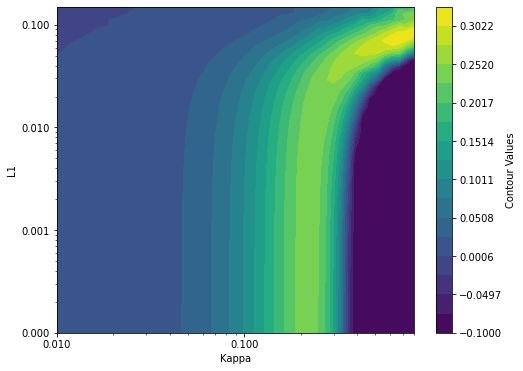

In [36]:
imported_anom_R2_OOS_df[imported_anom_R2_OOS_df < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

X_plot_a, Y_plot_a = np.meshgrid(kappa_grid, l1_grid)
Z = imported_anom_R2_OOS_df.values.T
plt.figure(figsize=(8,6))

levels = np.linspace(imported_anom_R2_OOS_df.values.min(), imported_anom_R2_OOS_df.values.max(), 18)
contour_plot = plt.contourf(X_plot_a, Y_plot_a, Z, levels=levels, cmap='viridis', linestyles=':')

plt.colorbar(label='Contour Values')

plt.xlabel('Kappa')
plt.ylabel('L1')

plt.xscale('log')
plt.xlim([min(kappa_grid), max(kappa_grid)])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()

## With PCA

In [34]:
bhat_pc_a, se_pc_a = b_hat_L2(X_pc_a, y_pc_a, gamma_opt_a, T_a, compute_errors=True)

anom_50_b_pc = pd.DataFrame(data=bhat_pc_a*100, index=[f'PC{i}' for i in range(1, 52)], columns=[f'b (Kappa = {round(kappa_opt_a, 3)})'])
anom_50_b_pc[f't-stat (Kappa = {round(kappa_opt_a, 3)})'] = abs(anom_50_b_pc[f'b (Kappa = {round(kappa_opt_a, 3)})'] / se_pc_a/100)
anom_50_b_pc = anom_50_b_pc.sort_values(by=f't-stat (Kappa = {round(kappa_opt_a, 3)})', ascending=False)

anom_50_b_pc.head(11)

,b (Kappa = 0.219),t-stat (Kappa = 0.219)
PC5,-0.591946,3.084821
PC1,0.435587,2.754067
PC4,0.261495,1.368606
PC2,0.240874,1.327756
PC14,0.246378,1.254655
PC9,-0.242013,1.237487
PC15,0.172033,0.875401
PC18,0.164441,0.834095
PC12,-0.147843,0.754960
PC6,0.132509,0.686164


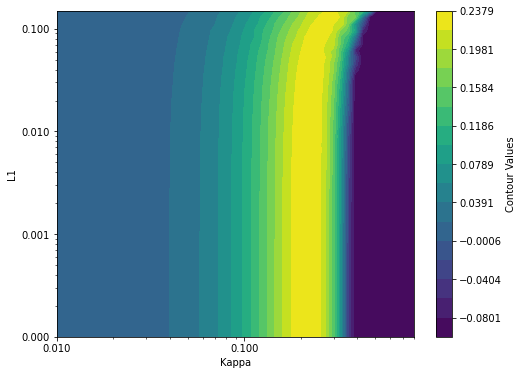

In [43]:
imported_anom_PC_R2_OOS_df[imported_anom_PC_R2_OOS_df < -0.1] = -0.1  # Enforcing minimum of -0.1 for R squarded values

X_plot_pc_a, Y_plot_pc_a = np.meshgrid(kappa_grid, l1_grid)
Z = imported_anom_PC_R2_OOS_df.values.T
plt.figure(figsize=(8,6))

levels = np.linspace(imported_anom_PC_R2_OOS_df.values.min(), imported_anom_PC_R2_OOS_df.values.max(), 18)
contour_plot = plt.contourf(X_plot_pc_a, Y_plot_pc_a, Z, levels=levels, cmap='viridis', linestyles=':')

plt.colorbar(label='Contour Values')

plt.xlabel('Kappa')
plt.ylabel('L1')

plt.xscale('log')
plt.xlim([min(kappa_grid), max(kappa_grid)])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()

## 50 Anomaly Portfolios with Interactions Analysis (NOT WORKING)
Here we try to extend the methodology by also considering interaction terms between each of the portfolios - in this case of 50 anomaly portfolios, we will be considering $\frac{50*51}{2} = 1275$ interactions terms.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def interactions(portfolio_returns):
    column_len = len(portfolio_returns.columns)
    test = portfolio_returns.copy()
    test.columns = range(1, column_len + 1)
    test_int = pd.DataFrame(index=test.index)

    column_name = column_len + 1
    for i in range(column_len):
        prod = 1
        prod_sum = 0
        for j in range(i + 1, column_len):
            prod = test.iloc[:, i] * test.iloc[:, j]
            prod_sum += prod
            test_int[column_name] = prod
            column_name += 1
        n_t = column_len - i
        test_int.iloc[:, 50*(i+1) - i - (51 - i - 1):50*(i+1) - 1] = test_int.iloc[:, 50*(i+1) - i - (51 - i - 1):50*(i+1) - 1].sub(prod_sum/n_t, axis=0)
        test_int.iloc[:, 50*(i+1) - i - (51 - i - 1):50*(i+1) - 1] = test_int.iloc[:, 50*(i+1) - i - (51 - i - 1):50*(i+1) - 1].div(test_int.iloc[:, 50*(i+1) - i - (51 - i - 1):50*(i+1) - 1].abs().sum(axis=1), axis=0)

    concat_df = pd.concat([portfolio_returns, test_int], axis=1)
    print(concat_df)
    scaler = StandardScaler()
    portfolio_returns = scaler.fit_transform(concat_df)
    portfolio_returns = pd.DataFrame(index=concat_df.index, columns=concat_df.columns, data=portfolio_returns)

    return portfolio_returns

In [ ]:
anomaly_interactions = interactions(anomalies_50)
train_ret_int, train_mkt_int, test_ret_int, test_mkt_int = split_data(anomaly_interactions, anomalies_mkt, "2004/12/31")
beta_fit = regression_against_market(train_ret_int, train_mkt_int)
train_ret_int, test_ret_int = orthogonalise_returns(train_ret_int, train_mkt_int, test_ret_int, test_mkt_int)
T_int, n_int = train_ret_int.shape
X_int, y_int, X_test_int, y_test_int, Q_int, eigenvalues_int = mean_covariance(train_ret_int, test_ret_int)
train_ret_pc_int, test_ret_pc_int = PC_rotate(train_ret_int, test_ret_int, Q_int)
X_pc_int, y_pc_int, X_test_pc_int, y_test_pc_int, _, _ = mean_covariance(train_ret_pc_int, test_ret_pc_int)

In [ ]:
kappa_grid_int = np.logspace(np.log10(0.01),np.log10(1.5), 50)
R2_OOS_int, R2_IS_int = cross_validation(kappa_grid_int, 3, train_ret_int, 252)

plt.figure(figsize=(8, 6))
plt.plot(kappa_grid_int,R2_OOS_int, label='OOS')
plt.plot(kappa_grid_int,R2_IS_int, label='IS')
plt.xscale('log')
plt.xticks(np.add(plt.xticks()[0], 0.0000000000001))
plt.xlim([min(kappa_grid_int), max(kappa_grid_int)])
plt.ylim([0, 0.5])
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ylabel('IS/OOS Cross-Sectional R$^2$', fontsize=12)
plt.xlabel('Root Expected SR$^2$ ($\kappa$)', fontsize=12)
plt.legend()

kappa_opt_L2 = kappa_grid_int[np.argmax(R2_OOS_int)]
kappa_opt_L2

In [ ]:
kappa_opt_int = 0.5
gamma_opt_int = gamma(kappa_opt_int, T_int, X_pc_int, 252)
bhat_int, se_int = b_hat_L2(X_pc_int, y_pc_int, gamma_opt_int, T_int, compute_errors=True)

In [ ]:
int_25_b = pd.DataFrame(data=bhat_int*100, index=[f'PC{i}' for i in range(1, 1327)], columns=['b'])
int_25_b['t-stat'] = abs(int_25_b['b']) / se_int / 100
int_25_b.nlargest(10, 't-stat')